In [1]:
""" mostly plotting results for rocky planet evolution + topographies """

%matplotlib inline
import numpy as np
import parameters as p
import matplotlib.pyplot as plt
from scipy import interpolate
import pandas as pd
from IPython.display import display, Math
import terrestrialplanet as tp
import thermal as therm
import topography as top

In [2]:
###### PLOTTING ######

def plot_output(pl, names, ncols=6, tspan=None, title=None, plots_save=False, verbose=True,
                compare_dir=None, fig_path='figs/', labelsize=15, legsize=10, lw=1, ls='-', print_tf=False,
                ident=None, fig=None, axes=None, label=None, **kwargs):

    if ident is None:
        ident = pl.ident
    
    t = pl.t # time points of ode solutions in s
    
    nrows = int(np.ceil(len(names)/ncols))
    if (fig is None) and (axes is None):
        fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3))
    if tspan is None:
        tspan = (0, t[-1]*1e-9/p.years2sec)
    out_vars = list(names.keys())
    ylabels = list(names.values()) # tuple (ylabel, yscale)
    if label is None:
        label = 'this work'
    for n, par in enumerate(out_vars):
        ax = axes.flatten()[n]
        y = eval('pl.'+par)
        if np.size(y)==1:
            y = [y]*len(t)
        try:
            yl = str(ylabels[n][0])
            plot_one(ax, t*1e-9/p.years2sec, y*ylabels[n][1], xlabel='', ylabel=yl, ls=ls, label=label)
            if compare_dir is not None: 
                try: # if data exists to benchmark this param
                    df = pd.read_csv(compare_dir+'/'+par+'.csv', header=None, names=['time', 'value'],
                                    index_col=False)
                    plot_one(ax, df['time'], df['value'], 
                             '', yl, c='r', labelsize=labelsize, legsize=legsize, lw=lw, ls=ls, 
                             label=compare_dir)

                except IOError:
                    #print('file', str(compare_dir+'/'+par+'.csv'), 'not found')
                    pass
            if par=='urey' and print_tf:
                ii = np.where(t*1e-9/p.years2sec<=tspan[-1])
                ax.annotate('%.2f'%(y[ii][-1]), xy=(tspan[-1], y[ii][-1]), fontsize=legsize, 
                            color='xkcd:bright purple',
                            textcoords="axes fraction", xytext=(1.05, 0.3),
                        #ha='center', va='bottom',
                            arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=-0.1",
                                           ec='xkcd:bright purple'))
            ax.set_xlim(tspan)
            ax.legend(frameon=False, fontsize=legsize)
        except ValueError as e:
            print('could\'t plot', par)
            print(e)
    
    while n+1 < ncols*nrows :
        fig.delaxes(axes.flatten()[n+1])
        n += 1 # hide unused axes
        
    plot_setxlabel(axes, 'Age (Gyr)', 'all')
    if title is None:
        title = pl.ident
    axes[0][0].set_title(title, fontsize=labelsize)
    plt.tight_layout()
    if plots_save:
        plt.savefig(fig_path+ident+'.pdf', bbox_inches='tight') 
    if verbose:
        print('\n        n timesteps =', len(t))
        print('$t_f$ =', t[-1]*p.sec2Gyr, 'Gyr')
        print(r'$R_p$ =', '%.2f'%(pl.R_p/p.R_E), 'R_E =', '%.2f'%(pl.R_p*1e-3), 'km')
#         print(r'$R_c$ =', '%.2f'%(kwargs['CRF']*kwargs['R_p']*1e-3), 'km')
        print('M_c', '%.2e'%pl.M_c, 'kg')   
        print(r'$M_{m+lid}$ =', '%.2e'%(pl.M_m), 'kg')
        print(r'$g_{sfc}$ =', '%.2f'%pl.g_sfc, 'm s^-2')
        print(r'$g_{cmb}$ =', '%.2f'%pl.g_cmb, 'm s^-2')
        print(r'$\kappa_m$', '%.6f'%pl.kappa_m, 'm^2 s^-1')
        print(r'CRF =', '%.2f'%pl.CRF)
        print(r'$h_0$ =', '%.2f'%(pl.h_rad_m[0]*1e12), 'pW kg^-1')
        print(r'$h_{4.5}$ =', '%.2f'%(pl.h_rad_m[-1]*1e12), 'pW kg^-1')
#         print(r'$H_0$ =', '%.2f'%(H_rad_m[0] + H_rad_lid[0]), 'TW')
#         print(r'$H_{4.5}$ =', '%.2f'%(H_rad_m[-1] + H_rad_lid[-1]), 'TW')
        print(r'Urey ratio @ $t_f$ =', '%.2f'%pl.urey[-1])
        print('q_sfc(t=0)', '%.2f'%(pl.q_sfc[0]*1e3), 'mW m^-3')
    return fig, axes

def snaps(pl, plot_snapshots=None, fig_path=None, plots_save=False, ident=None, **kwargs):
    if ident is None:
        ident = pl.ident
    
    t = pl.t # time points of ode solutions in s
    try:
        n_col = len(plot_snapshots)
    except:
        n_col = 1
    fig2, axes2 = plt.subplots(1, n_col,figsize=(3*n_col,5))
    for iax, tx in enumerate(plot_snapshots): # tx is the time value u want nearest
        ii = min(enumerate(t), key=lambda x: abs(tx - x[1]*p.sec2Gyr))[0]
        plot_structure(ax=axes2[iax], t=t[ii], T_m=pl.T_m[ii], T_c=pl.T_c[ii], T_s=pl.T_s,
                       T_l=pl.T_l[ii], R_l=pl.R_l[ii], R_p=pl.R_p, R_c=pl.R_c, h_rad_m=pl.h_rad_m[ii],
                       d_lbl = pl.TBL_c[ii], d_ubl = pl.TBL_u[ii], q_ubl = pl.q_ubl[ii], a0=pl.a0[ii],
                       k_m=pl.k_m, legsize=10, **kwargs)
    plt.tight_layout()
    if plots_save:
        fig2.savefig(fig_path+pl.ident+'_profiles.pdf', bbox_inches='tight') 
    return fig2, axes2

def plot_structure(ax=None, t=None, T_m=None, T_c=None, R_p=None, R_l=None, R_c=None, T_l=None, 
                   T_s=None, h_rad_m=None, d_lbl=None, d_ubl=None, q_ubl=None, a0=None, k_m=None,
                   labelsize=16, legsize=14, Tlid_ini=None, **kwargs):
    """ plot temp structure (for a given time) """
    r_c = np.linspace(0, R_c*1e-3)
    r_lbl = np.linspace(R_c*1e-3, (R_c+d_lbl)*(1e-3))
    r_m = np.linspace((R_c+d_lbl)*1e-3, (R_l-d_ubl)*1e-3) # radius for mantle in km
    r_ubl = np.linspace((R_l-d_ubl)*1e-3, (R_l)*1e-3)
    r_l = np.linspace(R_l*1e-3, R_p*1e-3) # radius for lid
    T_cond = therm.sph_conduction(r_l*1e3, a0=a0, T_l=T_l, R_p=R_p, R_l=R_l, T_s=T_s, k_m=k_m, **kwargs)
    q = therm.sph_flux(r_l*1e3, a0=a0, T_l=T_l, T_s=T_s, R_p=R_p, R_l=R_l, k_m=k_m, **kwargs)
    if Tlid_ini=='linear':
        T_cond = therm.sph_conduction(r_l*1e3, a0=0, T_l=T_l, R_p=R_p, R_l=R_l, T_s=T_s, k_m=k_m,**kwargs)
        q = therm.sph_flux(r_l*1e3, a0=0, T_l=T_l, T_s=T_s, R_p=R_p, R_l=R_l, k_m=k_m,**kwargs)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,5))
    ax.axhline(y=R_l*1e-3, ls='--', lw=1, c='xkcd:bluish purple')
    ax.axhline(y=R_c*1e-3, ls='--', lw=1, c='xkcd:clay')

    ax.plot(T_cond, r_l, c='xkcd:bluish purple')
    ax.plot(T_l + q_ubl/k_m*(R_l - r_ubl*1e3), r_ubl, c='xkcd:greenish')
    ax.plot([T_m]*len(r_m), r_m, c='xkcd:greenish')
    ax.plot([T_m, T_c], [(R_c+d_lbl)*1e-3, R_c*1e-3], c='xkcd:greenish', marker = None)
    ax.plot([T_c]*len(r_c), r_c, c='xkcd:clay')
        
    ax.set_ylabel('Radius (km)', fontsize=labelsize)
    ax.set_xlabel('Temperature (K)', fontsize=labelsize)
    ax.set_ylim([0, R_p*1e-3])
#     #ax.fill_between(x=x, y0=[0]*len(x), y1=[R_cmb*1e-3]*len(x), color='xkcd:gold') # core
    ax.text(T_cond[-1], 0, 'Core', ha='left', va='bottom', fontsize=legsize, c='xkcd:clay')
#     #ax.fill_between(x=x, y0=[R_cmb*1e-3]*len(x), y1=[R_p*1e-3]*len(x), color='xkcd:tomato') # mantle
    ax.text(T_cond[-1], R_c*1e-3, 'Convecting region', ha='left', va='bottom', fontsize=legsize, c='xkcd:greenish')
    ax.text(T_cond[-1], R_l*1e-3, 'Lid', ha='left', va='bottom', fontsize=legsize, c='xkcd:bluish purple')
    
    ax2 = ax.twiny()
    ax2.set_xlabel('Flux, steady-state (mW m$^{-2}$)', color='xkcd:grey')  
    ax2.plot(q*1e3, r_l, color='xkcd:grey')
    ax2.plot(q_ubl*1e3, r_ubl[0], marker='o', color='xkcd:grey')
    ax2.annotate('$q_{ubl}$', (q_ubl*1e3, r_ubl[-1]), color='xkcd:grey', fontsize=12, ha="left", va="top")
    ax2.tick_params(axis='x', labelcolor='xkcd:grey')
    
    ax.set_title(('%.1f'%(t*1e-9/p.years2sec))+' Gyr', fontsize=labelsize)

    return ax

def interp_benchmark(path, yscale=1):
    df = pd.read_csv(path, header=None, names=['time', 'value'], index_col=False) 
    f = interpolate.interp1d(np.array(df['time']), np.array(df['value'])*yscale, kind='linear')
    times = df['time'] # in Gyr 
    return np.array(times), f

def plot_qsfc_error(pl, ax3=None, compare_dir=None, fig_path=None, plots_save=False, ident=None, **kwargs):
    """ sanity check on q_sfc """
    if ident is None:
        ident = pl.ident
    
    t = pl.t # time points of ode solutions in s
    if ax3 is None:
        fig3, ax3 = plt.subplots(1, 1, figsize=(5,5))
        
    t_D_l, f_D_l_interp = interp_benchmark(path=compare_dir+'/D_l.csv', yscale=1e3) # in Gyr, m
    temp = t*1e-9/p.years2sec # in Gyr
    
    try:
        t_T_l, f_T_l_interp = interp_benchmark(path=compare_dir+'/T_l.csv')# in Gyr, K
        iii = np.where((temp>=t_T_l.min()) & (temp<=t_T_l.max()))
        times0 = temp[iii] # time points of ODE solver subset to interpolation range
        T_l_interp = f_T_l_interp(times0) # published plot interpolated to model times, in K
    except FileNotFoundError as e:
        t_T_l, f_T_avg_interp = interp_benchmark(path=compare_dir+'/T_avg.csv') # in Gyr, K
        iii = np.where((temp>=t_T_l.min()) & (temp<=t_T_l.max()))
        times0 = temp[iii] # time points of ODE solver subset to interpolation range
        T_avg_interp = f_T_avg_interp(times0) # published plot interpolated to model times, in K
        T_l_interp = Tl_from_Tmean(R_l=pl.R_l[iii], T_avg=T_avg_interp, a0=pl.a0[iii], **kwargs)
    

    D_l_interp = f_D_l_interp(times0) # published plot interpolated to model times, in m
    R_l_interp = pl.R_p - D_l_interp
    q_sfc_interp = therm.sph_flux(pl.R_p, a0=pl.a0[iii], T_l=T_l_interp, T_s=pl.T_s, R_l=R_l_interp, 
                                  R_p=pl.R_p, k_m=pl.k_m, **kwargs) # sfc flux in W m^-2

    ax3.plot(times0, pl.q_sfc[iii]*1e3, c='xkcd:black', label='this work')
    ax3.plot(times0, q_sfc_interp*1e3, c='xkcd:blue', label='Thiriet interp')
    df = pd.read_csv(compare_dir+'/q_sfc.csv', header=None, names=['time', 'value'],
                     index_col=False) # in Gyr, mW m^-3
    ax3.plot(df['time'], df['value'], c='xkcd:red', label='Thiriet digitised')
    ax3.legend(frameon=False, fontsize=14)
    ax3.set_xlabel('Time (Gyr)', fontsize=16)
    ax3.set_ylabel('$q_{sfc}$ (mW m$^{-2}$)', fontsize=16)

#     plt.tight_layout()

    fig0, ax0 = plt.subplots(1,1,  figsize=(4,4))
    ax0.plot(times0, pl.q_sfc[iii]*1e3 - q_sfc_interp*1e3, c='xkcd:grey')
    ax0.set_xlabel('Time (Gyr)', fontsize=14)
    ax0.set_ylabel('$\Delta q_{sfc}$ (mW m$^{-2}$)', fontsize=14)
    ax0.set_title('Mean error: $\pm$'+'%.2f'%np.mean(np.absolute(pl.q_sfc[iii]*1e3 - q_sfc_interp*1e3))+' mW m$^{-2}$', 
                  fontsize=14)
    plt.tight_layout()
    if plots_save:
        fig3.savefig(fig_path+pl.ident+'_test_qsfc.pdf')
        fig0.savefig(fig_path+pl.ident+'_q_error.pdf')

def plot_Tavg(pl, ax3=None, compare_dir=None, fig_path=None, plots_save=False, ident=None, **kwargs):
    """ sanity check on T_avg """
    if ident is None:
        ident = pl.ident
    
    t = pl.t # time points of ode solutions in s

    if ax3 is None:
        fig3, ax3 = plt.subplots(1, 1, figsize=(5,5))
        
    # plot your T_avg calculation but using interpolated published D_l    
    t_D_l, f_D_l_interp = interp_benchmark(path=compare_dir+'/D_l.csv', yscale=1e3) # in Gyr, m
    
    # select model time points in interpolation range
    temp = t*1e-9/p.years2sec # in Gyr
    iii = np.where((temp>=t_D_l.min()) & (temp<=t_D_l.max()))
    times0 = temp[iii] # time points of ODE solver subset to interpolation range
    D_l_interp = f_D_l_interp(times0) # published D_l at model time points in m
    R_l_interp = pl.R_p - D_l_interp # m
    
    T_avg_interp = therm.T_mean(T_m=pl.T_m[iii], T_l=pl.T_l[iii], R_p=pl.R_p, R_l=R_l_interp, 
                                R_c=pl.R_c, a0=pl.a0[iii], T_s=pl.T_s, k_m=pl.k_m, **kwargs)
    ax3.plot(times0, pl.T_avg[iii], c='xkcd:black', label='this work')
    ax3.plot(times0, T_avg_interp, c='xkcd:blue', label='this work with Thiriet D_l')
    df = pd.read_csv(compare_dir+'/T_avg.csv', header=None, names=['time', 'value'],
                     index_col=False) # in Gyr, mW m^-3
    ax3.plot(df['time'], df['value'], c='xkcd:red', label='Thiriet digitised')
    ax3.legend(frameon=False, fontsize=14)
    ax3.set_xlabel('Time (Gyr)', fontsize=16)
    ax3.set_ylabel('$T_{avg}$ (K)', fontsize=16)  
    ax3.set_title('blue should match red')
    
    plt.tight_layout()
    if plots_save:
        fig3.savefig(fig_path+pl.ident+'_test_Tavg.pdf')
        
def plot_one(ax, x, y, xlabel, ylabel, labelsize=15, legsize=16, lw=1, ls='-', marker=None, 
             ms=5, c='k', text=None, xticks=True, ylim=None, label=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    if not xticks:
        ax.set_xticks([])
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.plot(x, y, c=c, lw=lw, ls=ls, marker=marker, ms=ms, label=label)
    ax.set_xlim(x.min(), x.max())
    if text is not None:
        ax.text(0.05, 0.95, text, ha='left', va='top', transform=ax.transAxes, fontsize=legsize)
    return ax

def plot_setxlabel(axes, label, style, labelsize=15):
    ny, nx = np.shape(axes) # assume 2D
    for ii, ax in enumerate(axes):
        for jj, a in enumerate(ax):
            if (style=='all') or ((style=='bottom') and (jj==ny-1)):
                a.set_xlabel(label, fontsize=labelsize)
            if (style=='bottom') and (jj<ny-1):
                a.set_xticks([])
                
def Tl_from_Tmean(R_c=None, R_l=None, R_p=None, T_avg=None, T_s=None, a0=None, k_m=None, **kwargs):
    """solved for T_l using sympy"""
    return (k_m*(4*R_l**4 - 4*R_l**3*R_p - 3*R_l**2*R_p**2 + 2*R_l*R_p**3 + R_p**4)*(-60*Ea*R_c**6*k_m + 60*Ea*R_c**3*R_l**3*k_m + 30*Ea*R_c**3*R_l**2*R_p*k_m + 30*Ea*R_c**3*R_l*R_p**2*k_m - 30*Ea*R_l**5*R_p*k_m - 30*Ea*R_l**4*R_p**2*k_m + 120*R_b*R_c**3*R_l**3*T_avg*a_rh*k_m - 60*R_b*R_c**3*R_l**2*R_p*T_avg*a_rh*k_m - 60*R_b*R_c**3*R_l*R_p**2*T_avg*a_rh*k_m - 8*R_b*R_l**8*a0*a_rh + 14*R_b*R_l**7*R_p*a0*a_rh + 9*R_b*R_l**6*R_p**2*a0*a_rh - 20*R_b*R_l**5*R_p**3*a0*a_rh - 60*R_b*R_l**5*R_p*T_s*a_rh*k_m - 10*R_b*R_l**4*R_p**4*a0*a_rh - 30*R_b*R_l**4*R_p**2*T_s*a_rh*k_m + 18*R_b*R_l**3*R_p**5*a0*a_rh - 120*R_b*R_l**3*R_p**3*T_avg*a_rh*k_m + 180*R_b*R_l**3*R_p**3*T_s*a_rh*k_m + R_b*R_l**2*R_p**6*a0*a_rh + 60*R_b*R_l**2*R_p**4*T_avg*a_rh*k_m - 30*R_b*R_l**2*R_p**4*T_s*a_rh*k_m - 4*R_b*R_l*R_p**7*a0*a_rh + 60*R_b*R_l*R_p**5*T_avg*a_rh*k_m - 60*R_b*R_l*R_p**5*T_s*a_rh*k_m) - 2*sqrt(15)*sqrt(Ea*k_m**3*(60*Ea*R_c**6*k_m - 60*Ea*R_c**3*R_l**2*R_p*k_m - 60*Ea*R_c**3*R_l*R_p**2*k_m + 15*Ea*R_l**4*R_p**2*k_m + 30*Ea*R_l**3*R_p**3*k_m + 15*Ea*R_l**2*R_p**4*k_m - 240*R_b*R_c**3*R_l**3*T_avg*a_rh*k_m + 120*R_b*R_c**3*R_l**2*R_p*T_avg*a_rh*k_m + 120*R_b*R_c**3*R_l*R_p**2*T_avg*a_rh*k_m + 16*R_b*R_l**8*a0*a_rh - 28*R_b*R_l**7*R_p*a0*a_rh - 18*R_b*R_l**6*R_p**2*a0*a_rh + 40*R_b*R_l**5*R_p**3*a0*a_rh + 120*R_b*R_l**5*R_p*T_s*a_rh*k_m + 20*R_b*R_l**4*R_p**4*a0*a_rh + 60*R_b*R_l**4*R_p**2*T_s*a_rh*k_m - 36*R_b*R_l**3*R_p**5*a0*a_rh + 240*R_b*R_l**3*R_p**3*T_avg*a_rh*k_m - 360*R_b*R_l**3*R_p**3*T_s*a_rh*k_m - 2*R_b*R_l**2*R_p**6*a0*a_rh - 120*R_b*R_l**2*R_p**4*T_avg*a_rh*k_m + 60*R_b*R_l**2*R_p**4*T_s*a_rh*k_m + 8*R_b*R_l*R_p**7*a0*a_rh - 120*R_b*R_l*R_p**5*T_avg*a_rh*k_m + 120*R_b*R_l*R_p**5*T_s*a_rh*k_m))*(R_c - R_l)*(R_l - R_p)**2*(2*R_l + R_p)**2*(R_c**2 + R_c*R_l + R_l**2))/(30*R_b*R_l**2*a_rh*k_m**2*(R_l - R_p)**2*(2*R_l + R_p)**2*(4*R_l**4 - 4*R_l**3*R_p - 3*R_l**2*R_p**2 + 2*R_l*R_p**3 + R_p**4))

using Zeng radius model
using Zeng radius model
using Zeng radius model
using Zeng radius model


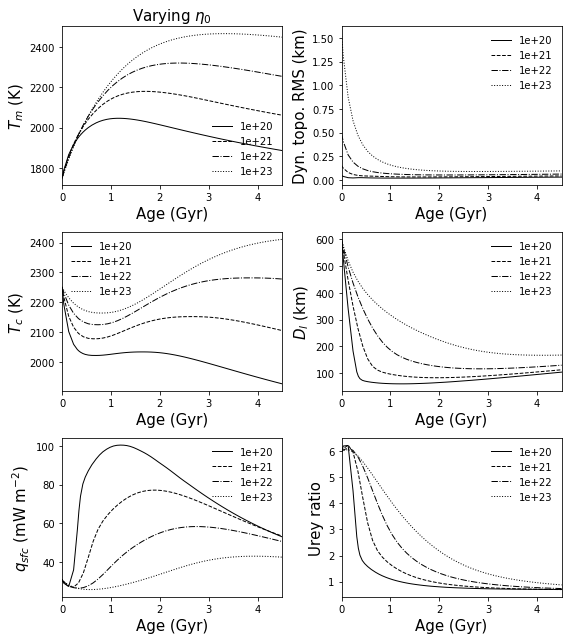

In [6]:
######  test effect of changing reference viscosity on Earth
# fig_path = '/space/cmg76/figs/' # office
fig_path = 'figs/' # laptop
# what to plot
names = {'T_m':('$T_m$ (K)',1), 
         'dyn_top_rms':('Dyn. topo. RMS (km)', 1e-3),
         'T_c':('$T_c$ (K)',1), 
         'D_l':('$D_l$ (km)',1e-3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'urey':('Urey ratio',1),
        }
save = False
ls = ['-', '--', '-.', ':']
for ii, eta_0 in enumerate([1e20, 1e21, 1e22, 1e23]):
    pl = tp.TerrestrialPlanet(Alb=0, 
                                 H_0 = 4.6e-12, # radiogenic heating in W/kg at 4.5 Gyr from Javoy (1999) BSE estimate from CI chondrites
                                 L=1, 
                                 Ra_crit_u=450, 
                                 alpha_m=2.5e-5, # thermal expansivity
                                 k_m=4, # silicate thermal conductivity
                                 CMF=0.3, # not used
                                 rho_c=7200, # core density
                                 rho_m=3500, # mantle density 
                                 rho_lith=None, 
                                 c_m=1142, #<----??? TODO: check if you need constant volume c_p
                                 c_c=840, # specific heat for core in J/K/kg
                                 k_lm=4, # thermal conduvtivity lower mantle
                                 beta_u=None, # defaults to 1/3
                                 beta_c=None, # defaults to 1/3 
                                 a_rh=2.44, # for beta=1/3 
                                 Ea=300e3, # activation energy in J for viscosity law
                                 eta_0=eta_0, # reference dynamic viscosity in Pa s
                                 T_ref=1600, # viscosity law reference temperature in K
                                 M_p=p.M_E, # only used for gravity in this case
                                 sma=1, 
                                 )

    kwargs = dict(T_m0=1750, T_c0=2250, D_l0=600e3, t0=0, tf=4.5, visc_type='Thi', complexity=3) # model params

    pl = therm.solve(pl, **kwargs) # T_m, T_c, D_l
    pl.dyn_top_rms = top.dyn_topo(pl.q_sfc, rho_m=pl.rho_m, rho_w=0, alpha_m=pl.alpha_m, eta_m=pl.eta_m,
                                  kappa_m=pl.kappa_m, g_sfc=pl.g_sfc, k_m=pl.k_m, C=5.4, **kwargs)
    if ii==0:
        fig=None
        axes=None
    fig, axes = plot_output(pl, names, ncols=2, plots_save=save, fig=fig, axes=axes, ls=ls[ii],
                            label=str(eta_0), verbose=False, fig_path=fig_path, title='Varying $\eta_0$', **kwargs)







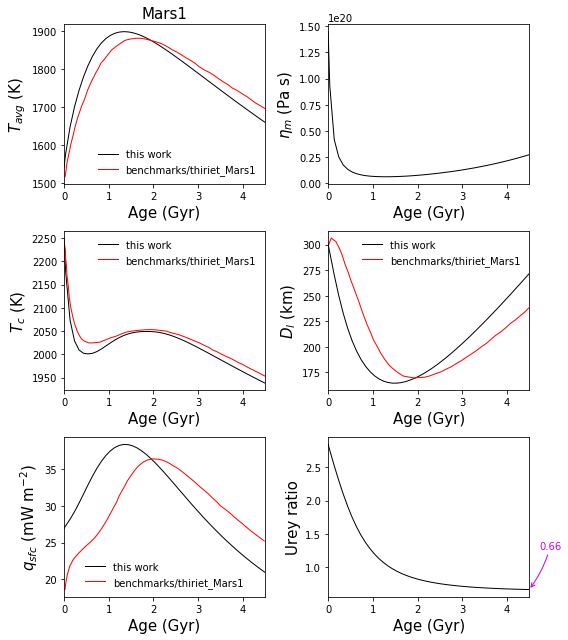

In [4]:
######  reproduce Thiriet+ 2019 Mars1
# fig_path = '/space/cmg76/figs/' # office
fig_path = 'figs/' # laptop
Mars1 = tp.TerrestrialPlanet(Alb=None, 
                             H_0=4e-12, # final radiogenic heating in W/kg
                             X_K=305, # initial abundance of K in wt ppm
                             X_U=16e-3, # initial abundane of U in wt ppm 
                             X_Th=56e-3, # initial abundance of Th in wt ppm 
                             L=None, 
                             Ra_crit_u=450, 
                             R_p0=3400e3, 
                             R_c0=1700e3,
                             alpha_m=2.5e-5, # thermal expansivity
                             k_m=4, # silicate thermal conductivity
                             CMF=0.24, # not used
                             rho_c=7200, # core density
                             rho_m=3500, # mantle density 
                             rho_lith=None, 
                             c_m=1142, #<----??? TODO: check if you need constant volume c_p
                             c_c=840, # specific heat for core in J/K/kg
                             k_lm=4, # thermal conduvtivity lower mantle
                             beta_u=None, # defaults to 1/3
                             beta_c=None, # defaults to 1/3 
                             a_rh=2.44, # for beta=1/3 
                             Ea=300e3, # activation energy in J for viscosity law
                             eta_0=1e21, # reference dynamic viscosity in Pa s
                             T_ref=1600, # viscosity law reference temperature in K
                             T_s=250, # fixed surface temp in K
                             M_p=6.39e23, # only used for gravity in this case
                             sma=None, 
                             ident='Mars1'
                             )

kwargs = dict(T_m0=1750, T_c0=2250, D_l0=300e3, t0=0, tf=4.5, visc_type='Thi', complexity=3) # model params

Mars1 = therm.solve(Mars1, **kwargs) # T_m, T_c, D_l

# what to plot
names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'T_c':('$T_c$ (K)',1), 
         'D_l':('$D_l$ (km)',1e-3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'urey':('Urey ratio',1),
        }

save = True
# snaps(Mars1_complex3, plot_snapshots=[0, 2, 4.5], fig_path=fig_path, plots_save=save, **kwargs)
fig, axes = plot_output(Mars1, names, ncols=2, plots_save=save,
            verbose=False, compare_dir='benchmarks/thiriet_Mars1',fig_path=fig_path, **kwargs)
# plot_qsfc_error(Mars1_complex3, compare_dir='benchmarks/thiriet_Mars1', fig_path=fig_path, plots_save=save, 
#                 ident='Mars1', **kwargs)
# plot_Tavg(Mars1_complex3, compare_dir='benchmarks/thiriet_Mars1', plots_save=save, 
#           fig_path=fig_path, **kwargs)

# expect q_sfc to be off by <=4.5 mW m^-3 average without PDE


        n timesteps = 66
$t_f$ = 4.5 Gyr
$R_p$ = 0.27 R_E = 1740.00 km
M_c 1.79e+21 kg
$M_{m+lid}$ = 7.20e+22 kg
$g_{sfc}$ = 1.62 m s^-2
$g_{cmb}$ = 0.79 m s^-2
$\kappa_m$ 0.000001 m^2 s^-1
CRF = 0.22
$h_0$ = 25.69 pW kg^-1
$h_{4.5}$ = 7.00 pW kg^-1
Urey ratio @ $t_f$ = 0.86
q_sfc(t=0) 25.90 mW m^-3


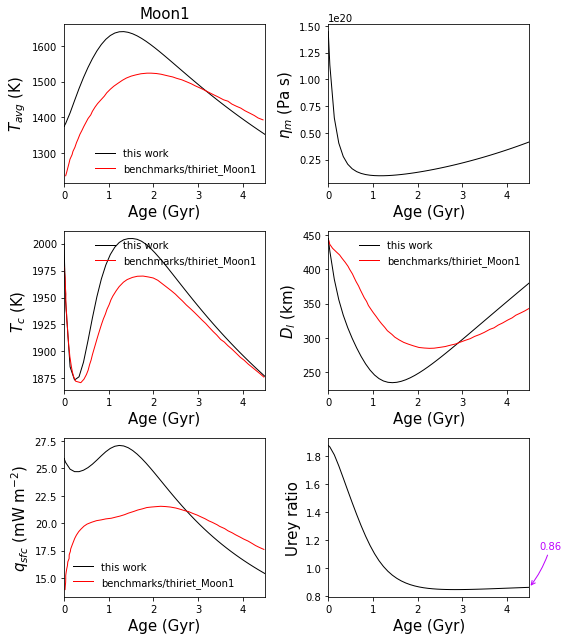

In [5]:
######  reproduce Thiriet+ 2019 Moon1
# fig_path = '/space/cmg76/figs/' # office
fig_path = 'figs/' # laptop
Moon1 = tp.TerrestrialPlanet(M_p = 7.34767309e22,
                            R_p0 = 1740e3,
                            R_c0 = 390e3,
                            Ra_crit_u = 450,
                            rho_m = 3300,
                            rho_c = 7200,
                            c_m = 1142,
                            c_c = 840,
                            beta_u = 0.346, # defaults to 1/3
                            beta_c = None, # defaults to 1/3
                            a_rh = 2.44,
                            k_m = 4,
                            k_lm = 4,
                            alpha_m = 2.5e-5,
                            T_s = 250,
                            Ea = 300e3,
                            eta_0 = 1e21,
                            T_ref = 1600,
                            X_K = 83, # initial abundance of K in wt ppm 
                            X_U = 33e-3, # initial abundane of U in wt ppm 
                            X_Th = 125e-3, # initial abundance of Th in wt ppm 
                            H_0 = 7e-12, # radiogenic heating in W/kg at t_f
                            ident = 'Moon1'
                            )

kwargs = dict(T_m0=1750, T_c0=2000, D_l0=445e3, t0=0, tf=4.5, visc_type='Thi', complexity=3) # model params


Moon1 = therm.solve(Moon1, **kwargs)

names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'T_c':('$T_c$ (K)',1), 
         'D_l':('$D_l$ (km)',1e-3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'urey':('Urey ratio',1),
        }

save=True
# snaps(f_Moon1, plot_snapshots=[0, 1, 4.5], fig_path=fig_path, plots_save=save, ident=ident, **kwargs)
plot_output(Moon1, names, ncols=2, plots_save=save, compare_dir='benchmarks/thiriet_Moon1', 
            fig_path=fig_path, tspan=(0, 4.5), **kwargs)



        n timesteps = 70
$t_f$ = 4.5 Gyr
$R_p$ = 0.38 R_E = 2440.00 km
M_c 2.45e+23 kg
$M_{m+lid}$ = 9.39e+22 kg
$g_{sfc}$ = 3.68 m s^-2
$g_{cmb}$ = 4.05 m s^-2
$\kappa_m$ 0.000001 m^2 s^-1
CRF = 0.82
$h_0$ = 29.99 pW kg^-1
$h_{4.5}$ = 5.00 pW kg^-1
Urey ratio @ $t_f$ = 0.52
q_sfc(t=0) 37.22 mW m^-3


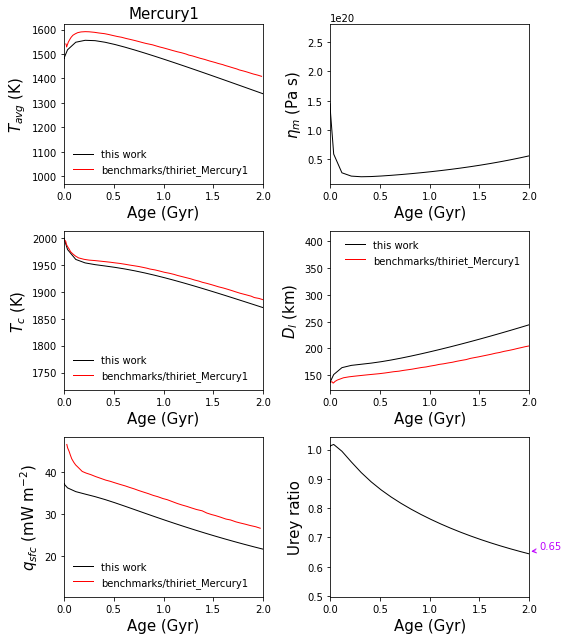

In [6]:
######  reproduce Thiriet+ 2019 Mercury1
fig_path = '/space/cmg76/figs/' # office
fig_path = 'figs/' # laptop
Mercury1 = tp.TerrestrialPlanet(M_p = 3.285e23,
                                R_p0 = 2440e3,
                                R_c0 = 2010e3,
                                Ra_crit_u = 450,
                                rho_m = 3500,
                                rho_c = 7200,
                                c_m = 1142,
                                c_c = 840,
                                beta_u = 0.335, # defaults to 1/3
                                beta_c = None, # defaults to 1/3
                                a_rh = 2.54, 
                                k_m = 4,
                                k_lm = 4,
                                alpha_m = 2.5e-5,
                                T_s = 440,
                                # viscosity 
                                Ea = 300e3,
                                eta_0 = 1e21,
                                T_ref = 1600,
                                X_K = 400, # initial abundance of K in wt ppm 
                                X_U = 28e-3, # initial abundane of U in wt ppm 
                                X_Th = 50e-3, # initial abundance of Th in wt ppm 
                                H_0 = 5e-12, # radiogenic heating in W/kg at t_f
                                ident='Mercury1'
                            )

# what to plot
names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'T_c':('$T_c$ (K)',1), 
         'D_l':('$D_l$ (km)',1e-3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'urey':('Urey ratio',1),
        }
kwargs = dict(T_m0=1750, T_c0=2000, D_l0=137e3, t0=0, tf=4.5, visc_type='Thi', complexity=3) # model params


Mercury1 = therm.solve(Mercury1, **kwargs)

save=False
# snaps(Mercury1, plot_snapshots=[0, 4.5], fig_path=fig_path, plots_save=save, ident=ident, **kwargs)
plot_output(Mercury1, names, tspan=(0, 2), ncols=2, plots_save=save, fig_path=fig_path,
            compare_dir='benchmarks/thiriet_Mercury1', **kwargs)



        n timesteps = 66
$t_f$ = 4.5 Gyr
$R_p$ = 0.95 R_E = 6051.80 km
M_c 7.36e+23 kg
$M_{m+lid}$ = 2.89e+24 kg
$g_{sfc}$ = 8.87 m s^-2
$g_{cmb}$ = 5.84 m s^-2
$\kappa_m$ 0.000001 m^2 s^-1
CRF = 0.48
$h_0$ = 22.66 pW kg^-1
$h_{4.5}$ = 4.60 pW kg^-1
Urey ratio @ $t_f$ = 0.71
q_sfc(t=0) 27.78 mW m^-3


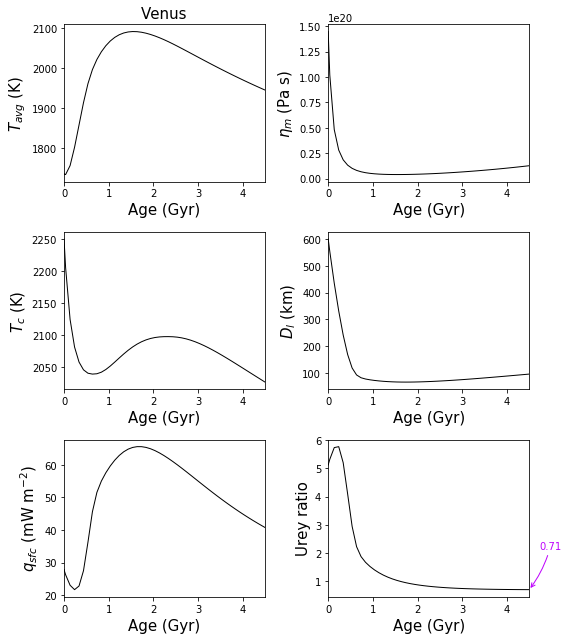

In [7]:
######  extrapolate Thiriet+ 2019 to Venus
fig_path = '/space/cmg76/figs/' # office
fig_path = 'figs/' # laptop
Venus = tp.TerrestrialPlanet(M_p = 4.867e24,
                                R_p0 = 6051.8e3,
                                R_c0 = 2900e3,
                                Ra_crit_u = 450,
                                rho_m = 3500,
                                rho_c = 7200,
                                c_m = 1142,
                                c_c = 840,
                                beta_u = 0.335, # defaults to 1/3
                                beta_c = None, # defaults to 1/3
                                a_rh = 2.54 ,
                                k_m = 4,
                                k_lm = 4,
                                alpha_m = 2.5e-5,
                                T_s = 467+273,
                                # viscosity 
                                Ea = 300e3,
                                eta_0 = 1e21,
                                T_ref = 1600,
                                H_0 = 4.6e-12, # radiogenic heating in W/kg at 4.5 Gyr from Javoy (1999) BSE estimate from CI chondrites
                                ident = 'Venus',
                            )
                             
# what to plot
names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'T_c':('$T_c$ (K)',1), 
         'D_l':('$D_l$ (km)',1e-3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'urey':('Urey ratio',1),
        }

kwargs = dict(T_m0 = 1750,T_c0 = 2250,D_l0 = 600e3,t0=0, tf=4.5, visc_type='Thi', complexity=3)

Venus = therm.solve(Venus, **kwargs)

save=False
# snaps(Venus, plot_snapshots=[0, 4.5], fig_path=fig_path, plots_save=save, ident=ident, **kwargs)
plot_output(Venus, names, ncols=2, plots_save=save, fig_path=fig_path, **kwargs)
# plot_qsfc_error(Venus, fig_path=fig_path, plots_save=save,
#                 ident=ident, **kwargs)


using Zeng radius model

        n timesteps = 66
$t_f$ = 4.5 Gyr
$R_p$ = 1.01 R_E = 6415.60 km
M_c 1.79e+24 kg
$M_{m+lid}$ = 4.18e+24 kg
$g_{sfc}$ = 9.68 m s^-2
$g_{cmb}$ = 9.68 m s^-2
$\kappa_m$ 0.000001 m^2 s^-1
CRF = 0.55
$h_0$ = 22.66 pW kg^-1
$h_{4.5}$ = 4.60 pW kg^-1
Urey ratio @ $t_f$ = 0.70
q_sfc(t=0) 30.63 mW m^-3


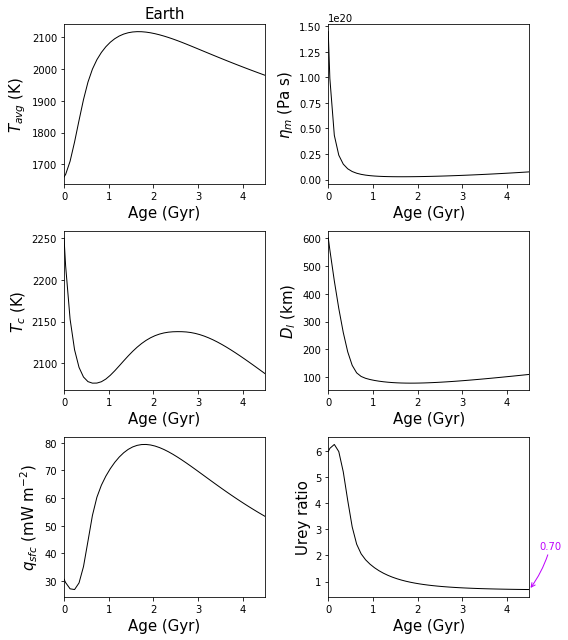

In [8]:
######  extrapolate Thiriet+ 2019 to Earth
fig_path = '/space/cmg76/figs/' # office
fig_path = 'figs/' # laptop
Earth = tp.TerrestrialPlanet(M_p = p.M_E, 
                            CMF = 0.3,
                            sma = 1,
                            L=1,
                            Alb=0,
                            Ra_crit_u = 450,
                            rho_m = 3500,
                            rho_c = 7200,
                            c_m = 1142,
                            c_c = 840,
                            beta_u = 0.335, # defaults to 1/3
                            beta_c = None, # defaults to 1/3
                            a_rh = 2.54 ,
                            k_m = 4,
                            k_lm = 4,
                            alpha_m = 2.5e-5,
                            # viscosity 
                            Ea = 300e3,
                            eta_0 = 1e21,
                            T_ref = 1600,
                            H_0 = 4.6e-12, # radiogenic heating in W/kg at 4.5 Gyr from Javoy (1999) BSE estimate from CI chondrites
                            ident = 'Earth'
                            )
                             
# what to plot
names = {'T_avg':('$T_{avg}$ (K)',1), 
         'eta_m':('$\eta_m$ (Pa s)', 1),#'q_core':('$q_{core}$ (mW m$^{-2}$)',1e3), 
         'T_c':('$T_c$ (K)',1), 
         'D_l':('$D_l$ (km)',1e-3), 
         'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)',1e3),
         'urey':('Urey ratio',1),
        }

kwargs = dict(T_m0=1750, T_c0=2250, D_l0=600e3, t0=0, tf=4.5, visc_type='Thi', complexity=3)

Earth = therm.solve(Earth, **kwargs)

save=True
# snaps(Earth, plot_snapshots=[0, 4.5], fig_path=fig_path, plots_save=save, **kwargs)
plot_output(Earth, names, ncols=2, plots_save=save, fig_path=fig_path,
            **kwargs)


In [ ]:
###### reproduce Nimmo & McKenzie 1997 

T_m0 = 3000 # initial mantle temp in K
T_c0 = 3000 # initial core temp in K
M_p = 1 # M_E
CMF = 0.3
t_f = 4 # Gyr
nu_m=5.5e15
rho_m=4800
alpha_m = 4e-5
k_m = 3.11
k_lm = 3.11
beta = 0.25
T_s = 450+273
visc_type='constant'


In [ ]:
###### reproduce Kite+ 2009 stagnant lid model (melting?) 

alpha_m = 3e-5
k_m = 4.18
c_pm = 914
rho_m = 3400
CMF = 0.325
T_m0 = 3273

In [ ]:
###### reproduce Venus fig 6 in Driscoll & Bercovici FAILED 
alpha_m = 3e-5
c_pm = 1265
k_m = 4.2
k_lm = 10
rho_m = 4800
M_p = 1 #4.867e24/M_E # M_E
CMF = 0.3
t_f = 4 # Gyr
T_m0 = 2510 # initial mantle temp in K
T_s = 737


In [219]:
# check radiogenic heating rates

c_n = np.array([U_0_238, U_0_235, Th_0, K_0])*np.array([1, 1, 56/16, 305e3/16])
p_n = [9.37e-5, 5.69e-4, 2.69e-5, 2.79e-5]
lambda_n = np.array([0.155, 0.985, 0.0495, 0.555])*1e-9/years2sec
tf = 4.5e9*years2sec
h_0 = h_rad(0, tf, 4e-12, c_n, p_n, lambda_n)
h_f = h_rad(4.5e9*years2sec, tf, 4e-12, c_n, p_n, lambda_n)
print('H_t0 =', h_0, 'W/kg =', h_0*6.39e23*1e-11, 'TW')
print('H_tf =', h_f, 'W/kg =', h_f*6.39e23*1e-11, 'TW')

H_t0 = 2.217642585962431e-11 W/kg = 141.70736124299933 TW
H_tf = 4e-12 W/kg = 25.56 TW


In [ ]:
# # possible variables to plot
# names={'T_m':('$T_m$ (K)', 1), 
#        'T_c':('$T_c$ (K)', 1), 
#        'D_l':('$D_l$ (km)', 1e-3), 
#        'eta_m':('$\eta_m$ (Pa s)', 1), 
#        'eta_cmb':('$\eta_{cmb}$ (Pa s)', 1), 
#        'TBL_u':('$TBL_u$ (km)', 1e-3),
#        'TBL_c':('$TBL_c$ (km)', 1e-3), 
#        'h_rad_m':('$h_{rad,m}$ (pW kg$^{-1}$)', 1e12), 
#        'H_rad_m':('$H_{rad,m}$ (TW)', 1e-12), 
#        'q_ubl':('$q_{ubl}$ (mW m$^{-2}$)', 1e3), 
#        'M_mi':('$M_{mantle}$ (kg)', 1),
#        'Q_ubl':('$Q_{ubl}$ (TW)', 1e-12),
#        'Q_core':('$Q_{core}$ (TW)', 1e-12), 
#        'q_sfc':('$q_{sfc}$ (mW m$^{-2}$)', 1e3), 
#        'Q_sfc':('$Q_{sfc}$ (TW)', 1e-12),
#        'q_core':('$q_{core}$ (mW m$^{-2}$)', 1e3), 
#        'urey':('Urey ratio', 1), 
#        'Ra_i':('Ra$_i$', 1)
#       } # format variable_name:(ylabel, scale)